In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import timm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
sample = glob('./data/train/*')[1524]
print(sample)
sample_csv = pd.read_csv(glob(sample + '/*.csv')[0])
sample_json = json.load(open(glob(sample + '/*.json')[0], 'r'))
sample_image = cv2.imread(glob(sample + '/*.jpg')[0])

./data/train\24936


In [3]:
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-10-17 12:50:00,39.9,40.1,39.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-10-17 12:40:00,39.6,39.8,39.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-10-17 12:30:00,39.1,39.3,38.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-10-17 12:20:00,38.5,38.8,38.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-10-17 12:10:00,38.0,38.2,37.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-10-15 12:40:00,24.3,25.1,23.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
290,2021-10-15 12:30:00,25.2,25.6,24.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
291,2021-10-15 12:20:00,24.6,25.4,23.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
292,2021-10-15 12:10:00,23.2,23.7,22.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


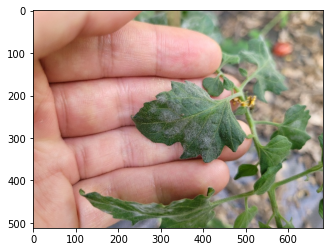

In [4]:
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
sample_json

{'description': {'date': '20211017',
  'image': '24936.jpg',
  'task': 1,
  'width': 682,
  'time': '1250',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'a5',
  'grow': 12,
  'bbox': [{'x': 229.6685681216931,
    'h': 196.0228587962963,
    'y': 164.81523850859787,
    'w': 274.5295138888889}],
  'part': [{'x': 282.3314318783069,
    'h': 52.66285342261905,
    'y': 166.76571800595238,
    'id': 0,
    'w': 154.5752314814815},
   {'x': 272.5790343915344,
    'h': 75.09333664021165,
    'y': 220.40381117724868,
    'id': 1,
    'w': 80.45713458994709},
   {'x': 354.01140873015873,
    'h': 73.14285714285714,
    'y': 259.900958994709,
    'id': 2,
    'w': 81.92001488095238}],
  'risk': 2,
  'crop': 2}}

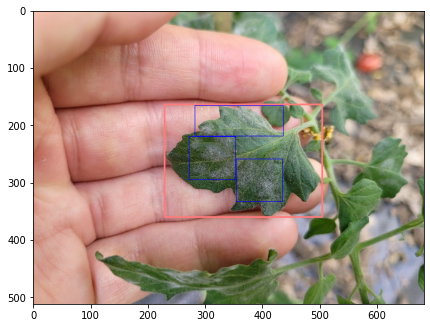

In [6]:
plt.figure(figsize=(7,7))
point = sample_json['annotations']['bbox'][0]
parts = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(point['x']), int(point['y'])),
    (int(point['x'] + point['w']), int(point['y'] + point['h'])),
    (255, 124, 124),
    2
)

for part in parts :
    cv2.rectangle(
        img,
        (int(part['x']), int(part['y'])),
        (int(part['x'] + part['w']), int(part['y'] + part['h'])),
        (0, 0, 255),
        1
    )
plt.imshow(img)
plt.show()

In [7]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', 
                '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', 
                '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('./data/train/*/*.csv'))

# csv_features에 있는 key들을 기준으로 pd 새로 만듬
temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

for csv in tqdm(csv_files[1:]) :
    temp_csv = pd.read_csv(csv)[csv_features]
    # 값이 없느면 - 으로 차있는데 이걸 Nan 으로 바꾸고 drop시킴
    temp_csv = temp_csv.replace('-', np.nan).dropna()
    # 모든값이 - 이라 전부 drop 되면 길이가 0
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    tmp_max, tmp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr, tmp_max], axis=0)
    min_arr = np.min([min_arr, tmp_min], axis=0)

csv_feature_dict = {csv_features[i] : [max_arr[i], min_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|███████████████████████████████████████████████████████████████████████████████| 5766/5766 [01:30<00:00, 63.53it/s]


{'내부 온도 1 평균': [47.3, 3.4],
 '내부 온도 1 최고': [47.6, 3.4],
 '내부 온도 1 최저': [47.0, 3.3],
 '내부 습도 1 평균': [100.0, 23.7],
 '내부 습도 1 최고': [100.0, 25.9],
 '내부 습도 1 최저': [100.0, 0.0],
 '내부 이슬점 평균': [34.5, 0.1],
 '내부 이슬점 최고': [34.7, 0.2],
 '내부 이슬점 최저': [34.4, 0.0]}

In [8]:
crop = {'1':'딸기',
        '2':'토마토',
        '3':'파프리카',
        '4':'오이',
        '5':'고추',
        '6':'시설포도'}

disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}

risk = {'1':'초기','2':'중기','3':'말기'}

In [12]:
label_description = {}
for k, v in disease.items() :
    label_description[f'{k}_00_0'] = f'{crop[k]}_정상'
    for disease_code in v : 
        for risk_code in risk :
            label = f'{k}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[k]}_{disease[k][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [14]:
label_description

{'1_00_0': '딸기_정상',
 '1_a1_1': '딸기_딸기잿빛곰팡이병_초기',
 '1_a1_2': '딸기_딸기잿빛곰팡이병_중기',
 '1_a1_3': '딸기_딸기잿빛곰팡이병_말기',
 '1_a2_1': '딸기_딸기흰가루병_초기',
 '1_a2_2': '딸기_딸기흰가루병_중기',
 '1_a2_3': '딸기_딸기흰가루병_말기',
 '1_b1_1': '딸기_냉해피해_초기',
 '1_b1_2': '딸기_냉해피해_중기',
 '1_b1_3': '딸기_냉해피해_말기',
 '1_b6_1': '딸기_다량원소결핍 (N)_초기',
 '1_b6_2': '딸기_다량원소결핍 (N)_중기',
 '1_b6_3': '딸기_다량원소결핍 (N)_말기',
 '1_b7_1': '딸기_다량원소결핍 (P)_초기',
 '1_b7_2': '딸기_다량원소결핍 (P)_중기',
 '1_b7_3': '딸기_다량원소결핍 (P)_말기',
 '1_b8_1': '딸기_다량원소결핍 (K)_초기',
 '1_b8_2': '딸기_다량원소결핍 (K)_중기',
 '1_b8_3': '딸기_다량원소결핍 (K)_말기',
 '2_00_0': '토마토_정상',
 '2_a5_1': '토마토_토마토흰가루병_초기',
 '2_a5_2': '토마토_토마토흰가루병_중기',
 '2_a5_3': '토마토_토마토흰가루병_말기',
 '2_a6_1': '토마토_토마토잿빛곰팡이병_초기',
 '2_a6_2': '토마토_토마토잿빛곰팡이병_중기',
 '2_a6_3': '토마토_토마토잿빛곰팡이병_말기',
 '2_b2_1': '토마토_열과_초기',
 '2_b2_2': '토마토_열과_중기',
 '2_b2_3': '토마토_열과_말기',
 '2_b3_1': '토마토_칼슘결핍_초기',
 '2_b3_2': '토마토_칼슘결핍_중기',
 '2_b3_3': '토마토_칼슘결핍_말기',
 '2_b6_1': '토마토_다량원소결핍 (N)_초기',
 '2_b6_2': '토마토_다량원소결핍 (N)_중기',
 '2_b6_3': '토마토_다량원소결핍 (N)_말기',
 '2_b7_1': 

In [15]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [34]:
a = np.zeros((144, 9))
a[-19:] = 1
aT = a.T
print(a.shape)
print(aT.shape)

(144, 9)
(9, 144)


In [106]:
class CustomDataset(Dataset) :
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0] * len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        
    def __len__(self) :
        return len(self.files)
    
    def __getitem__(self, i) :
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        # csv 
        if self.csv_feature_check[i] == 0 :
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            
            # Min Max Scaling
            for col in df.columns :
                # pd 는 boradcast 연산이 가능
                # 따라서 아래 수식들은 df 전체에 적용됨 numpy와 같음
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1] - self.csv_feature_dict[col][0])
                
            # Zero Padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            # 144와 df 길이 중 작은 값을 기준으로 padding 적용
            # 144가 더 작은 수면 pad 전체에 df[-144 : ] 값을 넣어줌
            # df의 길이가 더 작으면 pad[ -len(df):]에 df[-len(df):]값을 넣어줌
            # 그러면 pad[:-len(df)] 까지는 0으로 채워져있어서 padding이 형성됨
            pad[-length : ] = df.to_numpy()[-length : ]
            
            # Transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
            
        else :
            csv_feature = self.csv_features[i]
            
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train' :
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else :
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }


In [107]:
device = torch.device("cpu")
batch_size = 256
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 10
vision_pretrain = True
save_path = 'best_model.pt'
model_name = 'vit_base_patch16_224'

In [108]:
train = sorted(glob('./data/train/*'))
test = sorted(glob('./data/test/*'))

labelsss = pd.read_csv('data/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [109]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode='test')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델

### 이미지 분류 모델

In [110]:
class CNN_Encoder(nn.Module):
    def __init__(self, rate=0.1, model_name='vit_base_patch16_224'):
        super(CNN_Encoder, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

### 시계열 모델 : LSTM

In [111]:
class RNN_Decoder(nn.Module) :
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate) :
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features * embedding_dim, 1000)
        # cnn output + lstm output
        self.final_layer = nn.Linear(1000 + 10000, class_n)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, enc_out, dec_inp) :
        hidden, _ =self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        
        concat = torch.cat([enc_out, hidden], dim=1)
        
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

### CNN + LSTM 앙상블

In [112]:
class CNN2RNN(nn.Module) :
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate) :
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
    def forward(self, img, seq) :
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [113]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [115]:
def accuracy_function(real, pred) :
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    
    score = f1_score(real, pred, average='macro')
    return score

In [116]:
def train_step(batch_item, training) :
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    
    if training is True :
        model.train()
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast() :
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        score = accuracy_function(label, output)
        
        return loss, score
    else :
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [117]:
loss_plot, val_loss_plot = [], []
metric_plot,val_metric_plot = [], []

for epoch in range(epochs) :
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset :
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss # loss
        total_acc += batch_acc # score
        
        tqdm_dataset.set_postfix({
            'Epoch' : epoch + 1,
            'Loss' : '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch + 1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
        
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))

    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset :
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch' : epoch + 1,
            'Val Loss' : '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
        
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1] :
        torch.save(model.state_dict(), save_path)
        

0it [00:00, ?it/s]c:\users\sub\anaconda3\envs\torch-sub\lib\site-packages\torch\cuda\amp\autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
0it [00:36, ?it/s]


KeyboardInterrupt: 